In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 讀入整理好的數據集

In [4]:
train_set = pd.read_hdf("train_set0517.h5")
test_set = pd.read_hdf("test_set0517.h5")

### 篩選x_train, x_test要用的資料
### 用前一天的數據預測隔一天的天氣

In [5]:
x_train_data = train_set[['YEAR', 'MONTH', 'DAY', 'TMAX', 'TMIN', 'TAVG', 'PRCP']]
x_train_data = x_train_data.drop(x_train_data.index[-1])
x_test_data = test_set[['YEAR', 'MONTH', 'DAY', 'TMAX', 'TMIN', 'TAVG', 'PRCP']]
x_test_data = x_test_data.drop(x_test_data.index[-1])

In [6]:
from tensorflow.keras import backend as K

### 將x資料轉為floatx形式，並reshape以便訓練

In [7]:
x_train = K.cast_to_floatx(x_train_data.values.reshape((x_train_data.shape[0], 1, x_train_data.shape[1])))
x_test = K.cast_to_floatx(x_test_data.values.reshape((x_test_data.shape[0], 1, x_test_data.shape[1])))

### 篩選y_train, y_test要用的資料

In [8]:
y_train_TMIN_data = train_set[['TMIN_Interval']].astype(int)
y_train_TMIN = y_train_TMIN_data.drop(y_train_TMIN_data.index[0])

y_test_TMIN_data = test_set[['TMIN_Interval']].astype(int)
y_test_TMIN = y_test_TMIN_data.drop(y_test_TMIN_data.index[0])

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU

### 建立model
### 使用GRU訓練，加入兩層Dense，分別用relu及sigmoid
### loss採用sparse_categorical_crossentropy，optimizer用adam

In [10]:
TMIN_model = Sequential()
TMIN_model.add(GRU(256, dropout = 0.25, recurrent_dropout = 0.25, input_shape = (
    x_train.shape[1], x_train.shape[2])))
TMIN_model.add(Dense(100, activation = 'relu'))
TMIN_model.add(Dense(80, activation = 'sigmoid'))
TMIN_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
TMIN_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 256)               202752    
_________________________________________________________________
dense (Dense)                (None, 100)               25700     
_________________________________________________________________
dense_1 (Dense)              (None, 80)                8080      
Total params: 236,532
Trainable params: 236,532
Non-trainable params: 0
_________________________________________________________________


### 訓練模型20次

In [9]:
history = TMIN_model.fit(x_train, y_train_TMIN, batch_size = 50, epochs = 20, validation_data = (x_test, y_test_TMIN))

Train on 4060570 samples, validate on 414830 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
4060570/4060570 [==============================] - 529s 130us/sample - loss: 0.5665 - acc: 0.7860 - val_loss: 0.5484 - val_acc: 0.8043
Epoch 2/20
4060570/4060570 [==============================] - 570s 140us/sample - loss: 0.4715 - acc: 0.8153 - val_loss: 0.5037 - val_acc: 0.8177
Epoch 3/20
4060570/4060570 [==============================] - 556s 137us/sample - loss: 0.4432 - acc: 0.8312 - val_loss: 0.5188 - val_acc: 0.8113
Epoch 4/20
4060570/4060570 [==============================] - 552s 136us/sample - loss: 0.4272 - acc: 0.8379 - val_loss: 0.5052 - val_acc: 0.8117
Epoch 5/20
4060570/4060570 [==============================] - 552s 136us/sample - loss: 0.4247 - acc: 0.8370 - val_loss: 0.4933 - val_acc: 0.7694
Epoch 6/20
4060570/4060570 [==============================] - 562s 138us/sample - loss: 0.4203 - acc: 0.8388 - val_loss: 0.

### 繪製accuracy, loss訓練軌跡圖

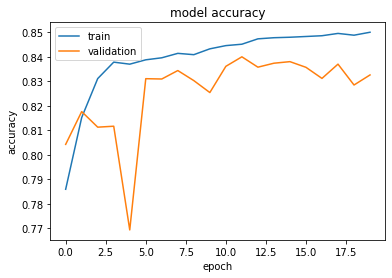

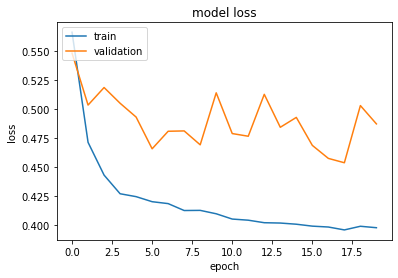

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [11]:
TMIN_model.save_weights('TMIN_model.h5')

In [12]:
TMIN_model.load_weights('TMIN_model.h5')

In [30]:
predict_data = pd.read_csv('氣象局觀測資料.csv')

In [32]:
predict_data = predict_data[['YEAR', 'MONTH', 'DAY', 'TMAX', 'TMIN', 'TAVG', 'PRCP']]
predict_data = K.cast_to_floatx(predict_data.values.reshape(predict_data.shape[0], 1, predict_data.shape[1]))

In [31]:
predict_data

,YEAR,MONTH,DAY,TMAX,TMIN,TAVG,PRCP
0,2020,5,15,32.1,22.6,27.200000,0.000000
1,2020,5,16,32.4,23.0,25.900000,0.458333
2,2020,5,17,31.9,21.7,25.441667,0.000000
3,2020,5,18,27.7,23.2,24.645833,0.291667
4,2020,5,19,24.0,21.8,21.841667,0.250000
5,2020,5,20,25.9,21.5,22.608333,0.312500
6,2020,5,21,27.9,22.7,24.300000,1.937500
7,2020,5,22,25.1,23.0,23.700000,3.229167


In [37]:
TMIN_result = TMIN_model.predict_classes(predict_data)

In [38]:
TMIN_result

array([15, 15, 15, 15, 15, 15, 15, 15], dtype=int64)